# 2.1 — Подготовка данных для регрессии

## Зачем вообще говорить о регрессии?

**Регрессия** предстказывает число!

Еще раз пример со стоимостью квартиры: по площади квартиры, этажу и расстоянию до метро мы хотим оценить цену. Модель подбирает формулу, которая максимально точно воспроизводит известные цены на обучающих данных, а затем применяет её к новым объектам.

- **Признак** (feature) — измеримая характеристика объекта: число комнат, плотность населения, средний доход
- **Целевая переменная** (target) — то, что пытаемся предсказать: в нашем случае медианная стоимость жилья

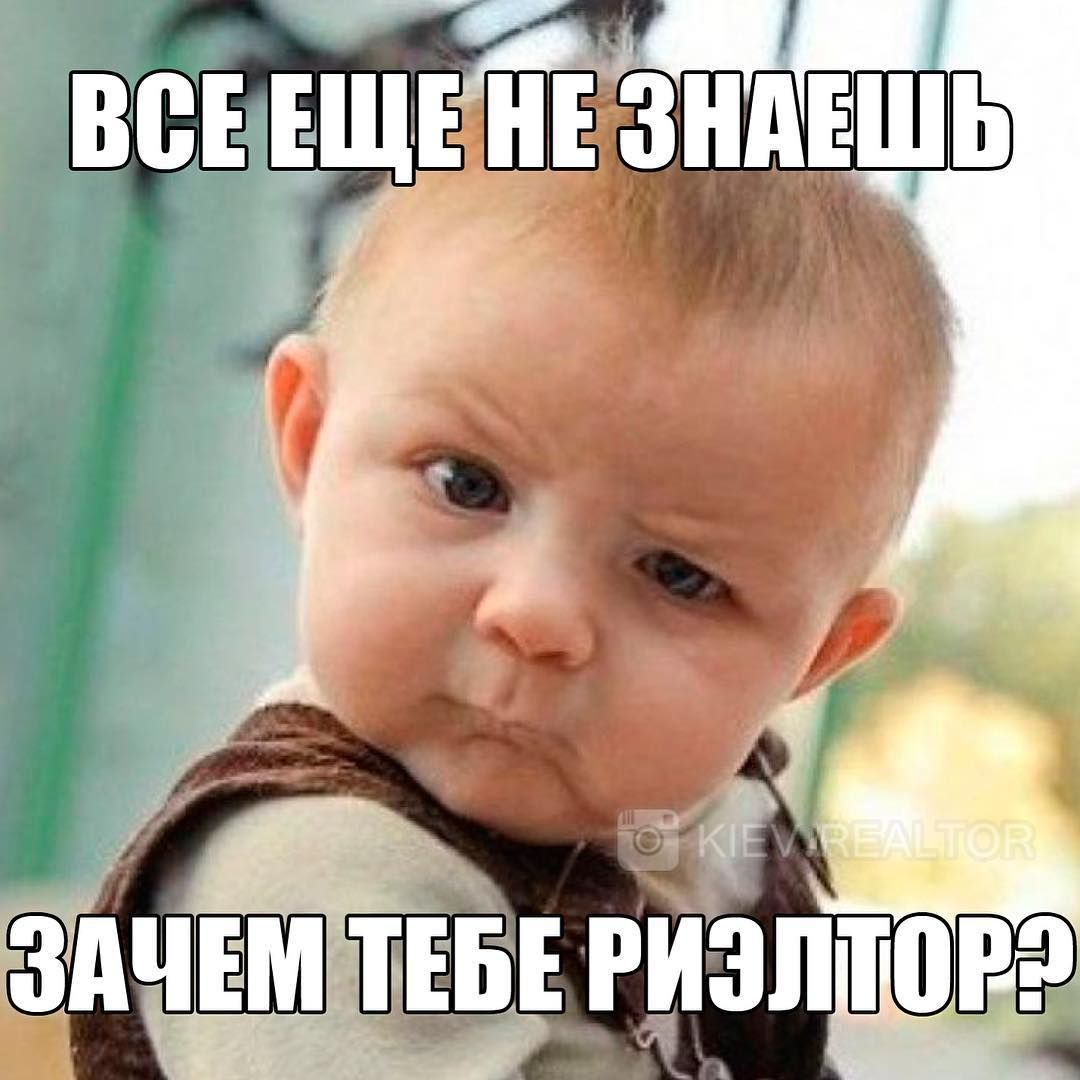

###  ```Вопрос??? Зачем нам вообще готовить какие-то данные?```
-> Мусор на взоде = мусор на выходе

## Импортируем библиотеки

In [1]:
!pip install numpy pandas seaborn scikit-learn
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [1]:
import numpy as np  # векторы и матрицы
import pandas as pd  # табличные данные

In [2]:
import seaborn as sns  # приятные статистические графики
import matplotlib.pyplot as plt  # базовые графики (hist, scatter, bar)

# стиль графиков
sns.set_theme(style="whitegrid", palette="deep")

# размерчик
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14

In [3]:
from pathlib import Path

In [4]:
from sklearn.datasets import fetch_california_housing  # сам датасет
from sklearn.model_selection import train_test_split  # делим данные на train/test
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures,
)
from sklearn.compose import ColumnTransformer  # конвейер для разных типов признаков
from sklearn.impute import SimpleImputer  # заполнение пропусков
from sklearn.pipeline import Pipeline  # сборка последовательности шагов
from sklearn.linear_model import LinearRegression  # простая модель
from sklearn.base import clone

In [5]:
from IPython.display import display
import joblib

np.random.seed(42)

## Шаг 1. Загружаем и исследуем данные

Используем `fetch_california_housing(as_frame=True)`

In [6]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

In [7]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
# ЦЕЛЕВАЯ ПЕРЕМЕННАЯ (медианная стоимость жилья)
target_name = "MedHouseVal"

X = df.drop(columns=target_name)
y = df[target_name]

In [9]:
print(f"Число наблюдений: {df.shape[0]}")
print(f"Число признаков (без таргета): {X.shape[1]}")

Число наблюдений: 20640
Число признаков (без таргета): 8


### Что означает каждый признак?

| Имя | Описание (человеческим языком) |
| --- | --- |
| `MedInc` | Медианный доход в районе (в десятках тысяч долларов). Например, значение `3.0` означает ~$30 000. |
| `HouseAge` | Средний возраст домов в районе (в годах). |
| `AveRooms` | Среднее количество комнат на один дом. |
| `AveBedrms` | Среднее количество спален на один дом. |
| `Population` | Численность населения района. |
| `AveOccup` | Среднее количество жильцов на дом. |
| `Latitude` | Широта района (географическая координата). |
| `Longitude` | Долгота района. |
| `MedHouseVal` | Целевой признак: медианная стоимость жилья (в сотнях тысяч долларов). |

``` ???? Зачем мы смотрим, что за колонки ????```

модель вообще ничего не знает, только что перед ней чиселки

### Добавим простые категориальные признаки

Чтобы показать работу с категориальными данными, создадим два признака:

- `Region`: север/юг штата по медианной широте
- `DensityLevel`: уровень плотности населения (низкая, средняя, высокая) по квантилям

In [10]:
latitude_median = df["Latitude"].median()
df["Region"] = np.where(df["Latitude"] >= latitude_median, "north", "south")

In [11]:
# получаем три равночисленных группы
population_bins = pd.qcut(df["Population"], q=3, labels=["low", "mid", "high"])
df["DensityLevel"] = population_bins.astype(str)

In [12]:
X = df.drop(columns=target_name)

display(df[["Population", "DensityLevel", "Latitude", "Region"]].head())

,Population,DensityLevel,Latitude,Region
0,322.0,low,37.88,north
1,2401.0,high,37.86,north
2,496.0,low,37.85,north
3,558.0,low,37.85,north
4,565.0,low,37.85,north


> ???? Зачем инженеру признаков придумывать категориальные столбцы ???

**Ответ:** категории позволяют захватить немонотонные эффекты. Например, северные районы могут быть дороже из-за климата, и линейная зависимость «Latitude → цена» это не уловит, а фиктивная переменная `Region=north` уже добавляет нужную информацию

## Шаг 2. Первичный осмотр данных (EDA)

EDA помогает заметить странности: пропуски, неадекватные диапазоны, выбросы. Идём от самых базовых проверок.

In [13]:
# краткая информация о типах данных и количестве непустых значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MedInc        20640 non-null  float64
 1   HouseAge      20640 non-null  float64
 2   AveRooms      20640 non-null  float64
 3   AveBedrms     20640 non-null  float64
 4   Population    20640 non-null  float64
 5   AveOccup      20640 non-null  float64
 6   Latitude      20640 non-null  float64
 7   Longitude     20640 non-null  float64
 8   MedHouseVal   20640 non-null  float64
 9   Region        20640 non-null  object 
 10  DensityLevel  20640 non-null  object 
dtypes: float64(9), object(2)
memory usage: 1.7+ MB


In [14]:
# статистики по числовым признакам: минимум, максимум, медиана, квартиль
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [15]:
# Доля пропусков в каждом столбце
missing_share = df.isna().mean().sort_values(ascending=False)
missing_share

,0
MedInc,0.0
HouseAge,0.0
AveRooms,0.0
AveBedrms,0.0
Population,0.0
AveOccup,0.0
Latitude,0.0
Longitude,0.0
MedHouseVal,0.0
Region,0.0


### Смотрим на распределения и асимметрию

Скошенное распределение означает, что у признака есть длинный «хвост». Среднее значение может оказаться далеким от большинства наблюдений.

 **Например зп Айтишников**

Большинство специалистов получают сопоставимо, но какие-то гошники «тянут хвост» в сторону мильонов

In [16]:
# коэффициенты асимметрии (skewness) для числовых признаков и сортируем
skewness = df.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
skewness

,0
AveOccup,97.639561
AveBedrms,31.316956
AveRooms,20.697869
Population,4.935858
MedInc,1.646657
MedHouseVal,0.977763
Latitude,0.465953
HouseAge,0.060331
Longitude,-0.297801


> Вопрос: Какой признак самый косой

Если хвост слишком длинный, можно применить логарифм: `np.log1p(AveOccup)`. Это похоже на то, как мы сжимаем шкалу громкости: логарифмическая шкала делает различия более читаемыми

### Визуализация распределений

как выглядят цены на жильё

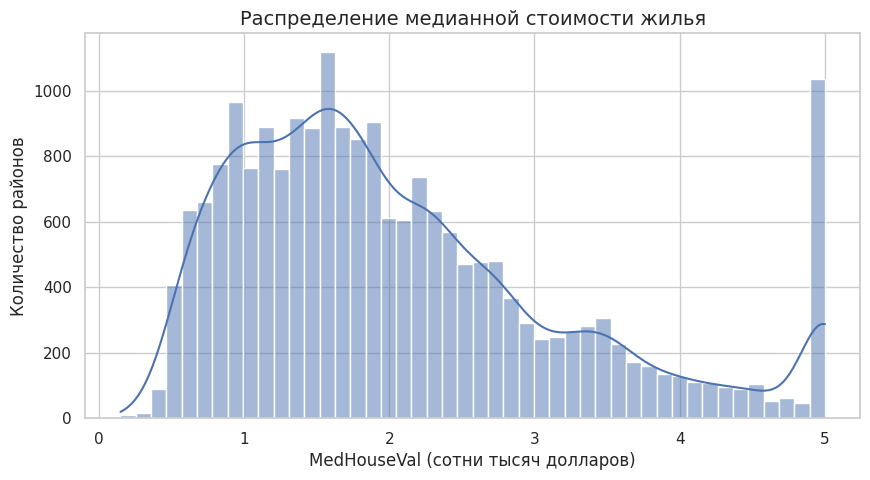

In [ ]:
sns.histplot(data=df, x=target_name, kde=True)
plt.title("Распределение медианной стоимости жилья")
plt.xlabel("MedHouseVal (сотни тысяч долларов)")
plt.ylabel("Количество районов")
plt.show()

Иногда логарифм помогает «сжать» длинный хвост. Посмотрим, как меняется распределение `MedHouseVal`, если применить `log1p` (логарифм от 1 + значение, чтобы не упасть в минус бесконечность).

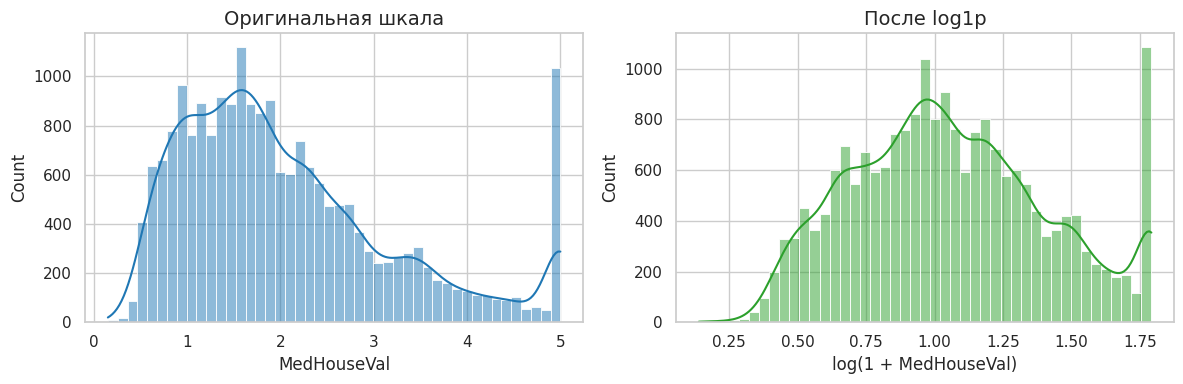

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df[target_name], ax=axes[0], kde=True, color="tab:blue")
axes[0].set_title("Оригинальная шкала")
axes[0].set_xlabel(target_name)

sns.histplot(np.log1p(df[target_name]), ax=axes[1], kde=True, color="tab:green")
axes[1].set_title("После log1p")
axes[1].set_xlabel("log(1 + MedHouseVal)")

plt.tight_layout()
plt.show()

> после логарифма хвост становится короче, и значения распределяются более равномерно. Это полезно, если модель плохо справляется с экстремальными значениями

### Отдельно смотрим на ключевые признаки

Для признаков, которые влияют на цены, строим гистограмму и диаграмму размаха (boxplot).

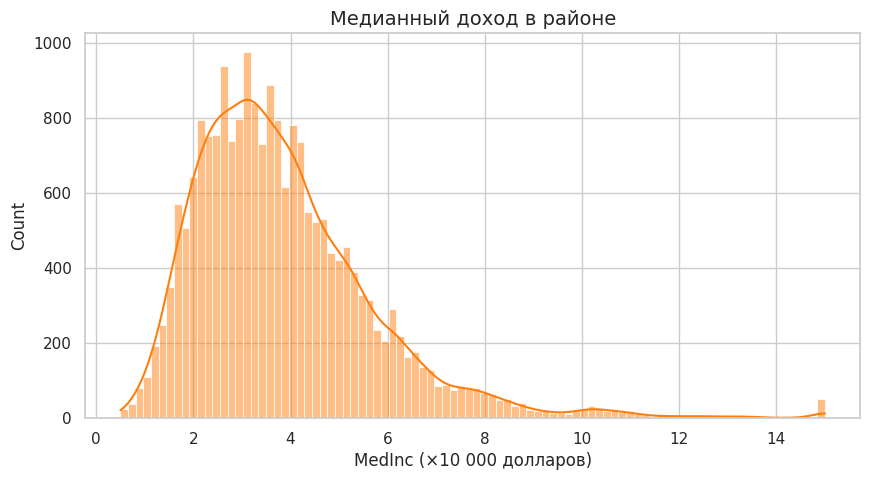

In [ ]:
sns.histplot(df["MedInc"], kde=True, color="tab:orange")
plt.title("Медианный доход в районе")
plt.xlabel("MedInc (×10 000 долларов)")
plt.show()

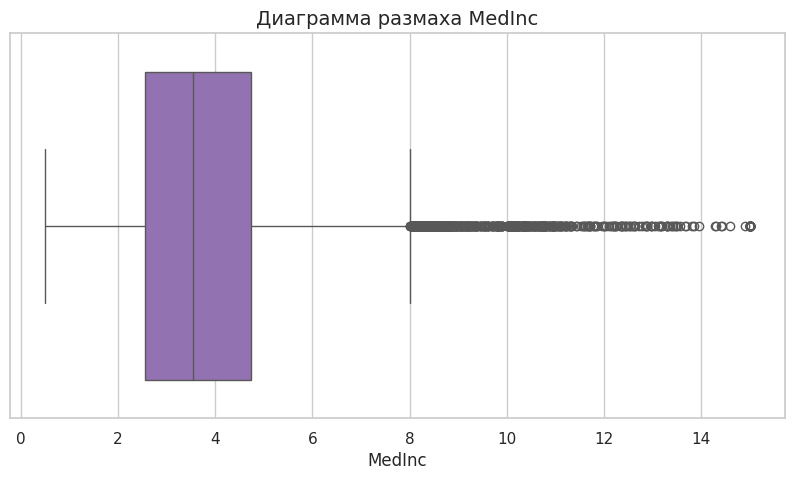

In [ ]:
# Boxplot для медианного дохода - удобен, чтобы заметить выбросы !!!
sns.boxplot(x=df["MedInc"], color="tab:purple")
plt.title("Диаграмма размаха MedInc")
plt.xlabel("MedInc")
plt.show()

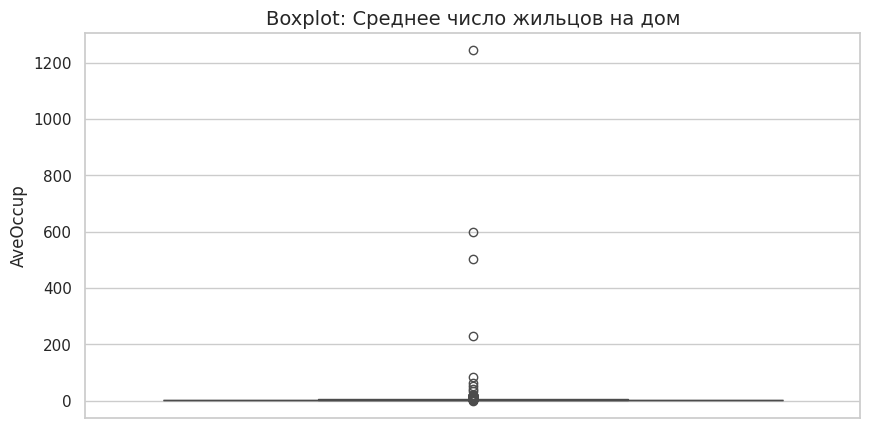

In [ ]:
sns.boxplot(y=df["AveOccup"])
plt.title("Boxplot: Среднее число жильцов на дом")
plt.ylabel("AveOccup")
plt.show()

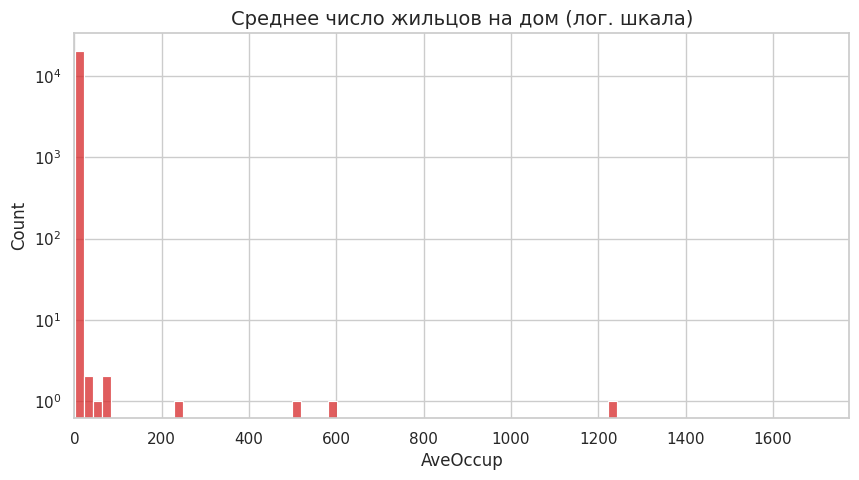

In [ ]:
sns.histplot(df["AveOccup"], bins=60, color="tab:red")
plt.yscale('log')
plt.title("Среднее число жильцов на дом (лог. шкала)")
plt.xlabel("AveOccup")
plt.xlim(0, 1775)
plt.show()

### Scatterplots: зависимость цены от признаков

Линейная регрессия ищет зависимость вида `цена = a * признак + b`. График рассеяния помогает увидеть, есть ли вообще линейный тренд

In [ ]:
sample = df.sample(4000, random_state=42)
print(f"Размер выборки для визуализации: {sample.shape[0]}")

Размер выборки для визуализации: 4000


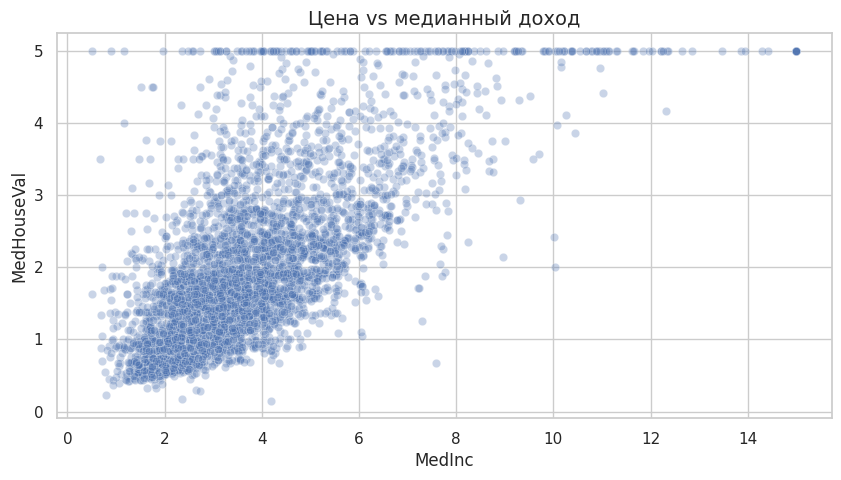

In [ ]:
# казалось бы связь ДОЛЖНА быть
sns.scatterplot(data=sample, x="MedInc", y=target_name, alpha=0.3)
plt.title("Цена vs медианный доход")
plt.xlabel("MedInc")
plt.ylabel("MedHouseVal")
plt.show()

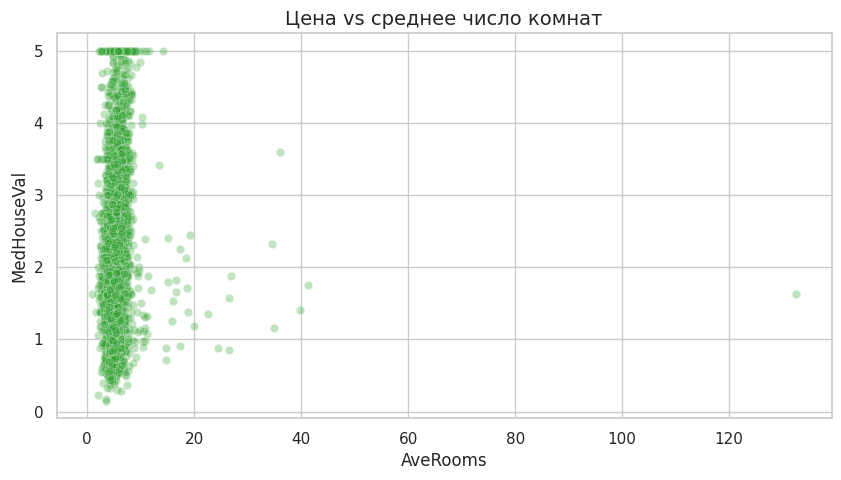

In [ ]:
sns.scatterplot(data=sample, x="AveRooms", y=target_name, alpha=0.3, color="tab:green")
plt.title("Цена vs среднее число комнат")
plt.xlabel("AveRooms")
plt.ylabel("MedHouseVal")
plt.show()

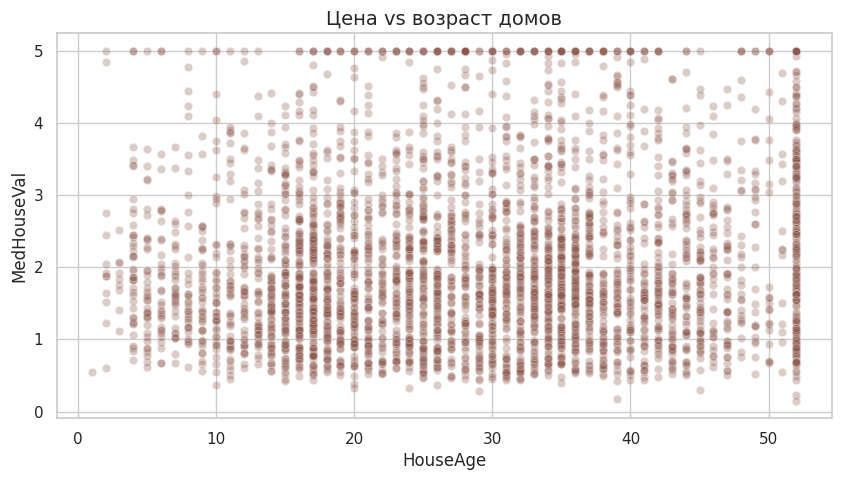

In [ ]:
# Цена vs возраст домов
sns.scatterplot(data=sample, x="HouseAge", y=target_name, alpha=0.3, color="tab:brown")
plt.title("Цена vs возраст домов")
plt.xlabel("HouseAge")
plt.ylabel("MedHouseVal")
plt.show()

> Ответ: линейная регрессия особенно любит, когда зависимость выглядит почти прямой линией. У `MedInc` это так, у `HouseAge` — не совсем, а значит, стоит подумать о дополнительных признаках или нелинейных моделях

### Корреляции и мультиколлинеарность

**Корреляция** показывает, как два признака «шагают» вместе. Если одновременно растут/падают, корреляция положительная. Мультиколлинеарность — ситуация, когда один признак почти линейно выражается через другой. Это как два термометра, стоящие рядом: дополнительной информации мало, а шум растёт

In [ ]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Выберем топ-6 признаков с максимальной корреляцией
top_features = corr_matrix[target_name].abs().sort_values(ascending=False).head(6).index

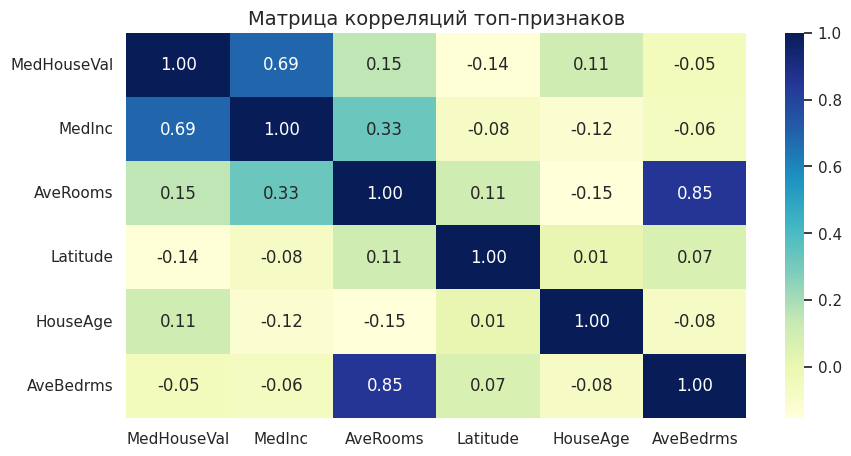

In [ ]:
# Теплокарта
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Матрица корреляций топ-признаков")
plt.show()

> видим, что `MedInc` наиболее сильно связан с ценой

## Шаг 3. Разбираемся с выбросами на игрушечном примере

Реальные данные часто содержат выбросы: ошибки измерения, редкие события. Чтобы понять методы, создадим небольшой синтетический набор

In [ ]:
# с коррелированными признаками и парой выбросов
rng = np.random.default_rng(42)
n_samples = 200

x1 = rng.normal(loc=0, scale=1, size=n_samples)  # основной признак
x2 = 0.9 * x1 + rng.normal(loc=0, scale=0.1, size=n_samples)  # почти копия x1
noise = rng.normal(0, 0.5, n_samples)
y_clean = 3 * x1 + noise  # целевой признак

In [ ]:
# Добавляем явные выбросы: две точки
x1_outliers = np.array([3.5, -3.2])
x2_outliers = 0.9 * x1_outliers + np.array([2.0, -1.5])
y_outliers = np.array([10.0, -9.0])

toy_df = pd.DataFrame({
    "x1": np.concatenate([x1, x1_outliers]),
    "x2": np.concatenate([x2, x2_outliers]),
    "y": np.concatenate([y_clean, y_outliers])
})

toy_df["point_type"] = ["regular"] * n_samples + ["outlier"] * len(x1_outliers)
toy_df.tail()

,x1,x2,y,point_type
197,-0.394605,-0.332223,-0.777515,regular
198,-0.005122,0.048397,0.105464,regular
199,-0.163443,-0.217566,-1.377810,regular
200,3.500000,5.150000,10.000000,outlier
201,-3.200000,-4.380000,-9.000000,outlier


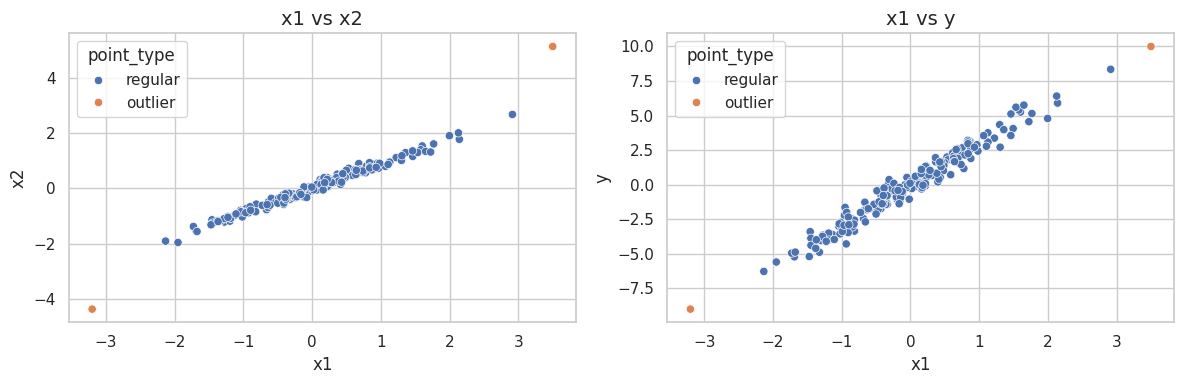

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=toy_df, x="x1", y="x2", hue="point_type", ax=axes[0])
axes[0].set_title("x1 vs x2")

sns.scatterplot(data=toy_df, x="x1", y="y", hue="point_type", ax=axes[1])
axes[1].set_title("x1 vs y")

plt.tight_layout()
plt.show()

> на графиках видно, что `x2` почти повторяет `x1`, а оранжевые точки выбросов «сбивают» тренд. Линейная регрессия в такой ситуации переоценивает влияние выбросов и делает коэффициенты нестабильными

### Метод 1. IQR (межквартильный размах)

Идея: считаем 25-й и 75-й процентили (`Q1`, `Q3`), вычисляем `IQR = Q3 - Q1`. Всё, что лежит ниже `Q1 - 1.5 * IQR` или выше `Q3 + 1.5 * IQR`, считаем выбросом. Это аналог того, как мы говорим: «Если рост человека сильно отличается от большинства, надо проверить, не ошибка ли это»

In [ ]:
def detect_outliers_iqr(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (series < lower) | (series > upper)
    return mask, lower, upper

In [ ]:
y_mask_iqr, lower_bound, upper_bound = detect_outliers_iqr(toy_df["y"])
print(f"Границы по IQR: [{lower_bound:.2f}, {upper_bound:.2f}]")
toy_df.loc[y_mask_iqr, ["x1", "x2", "y", "point_type"]]

Границы по IQR: [-7.05, 6.87]


,x1,x2,y,point_type
139,2.913862,2.683352,8.348305,regular
200,3.500000,5.150000,10.000000,outlier
201,-3.200000,-4.380000,-9.000000,outlier


### Метод 2. Robust Z-score

Классический Z-score использует среднее и стандартное отклонение — чувствительные к выбросам показатели. Robust Z-score заменяет их на медиану и MAD (median absolute deviation), поэтому устойчивее. Представьте, что нужно оценить средний доход в компании, где есть один миллиардер. Медиана устойчиво покажет доход обычного сотрудника

In [ ]:
def robust_zscore(series):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return pd.Series(np.zeros_like(series), index=series.index)
    return 0.6745 * (series - median) / mad

In [ ]:
# какие точки выходят за |z| > 3
robust_scores = robust_zscore(toy_df["y"])
flagged = toy_df.assign(robust_z=robust_scores).loc[robust_scores.abs() > 3]
display(flagged[["x1", "x2", "y", "robust_z", "point_type"]])

,x1,x2,y,robust_z,point_type
139,2.913862,2.683352,8.348305,3.222685,regular
200,3.500000,5.150000,10.000000,3.850761,outlier
201,-3.200000,-4.380000,-9.000000,-3.374206,outlier


> оба метода нашли наши искусственные выбросы. В реальных задачах решаем, что делать дальше: удалить, обрезать крайние значения или применить логарифм. Если выброс — всего лишь ошибка датчика, можно убрать. Если это редкий, но важный клиент, нужно обработать аккуратно

## Шаг 4. Работа с попусками

В датасете пропусков нет, поэтому добавим их искусственно и потренируемся

In [ ]:
# 2% значений в NaN
X_with_nan = X.copy()
rng = np.random.default_rng(123)
nan_fraction = 0.02
nan_mask = rng.random(X_with_nan.shape) < nan_fraction
X_with_nan = X_with_nan.mask(nan_mask)

In [ ]:
# Смотрим долю пропусков по числовым признакам
numeric_columns = X_with_nan.select_dtypes(include=[np.number]).columns
missing_after_injection = X_with_nan[numeric_columns].isna().mean().sort_values(ascending=False)
display(missing_after_injection.head(5))

,0
AveRooms,0.020107
MedInc,0.019816
AveOccup,0.019767
Population,0.019767
Longitude,0.019525


### Почему часто выбирают медиану?

Медиана — середина распределения. Если у нас есть экстремальные значения, среднее «уползёт» в их сторону, а медиана останется устойчивой. Это как в классе: если у всех рост от 160 до 180 см, а один баскетболист 210 см, средний рост сместится, а медиана почти не изменится

In [ ]:
median_imputer = SimpleImputer(strategy="median")

In [ ]:
sample_before = X_with_nan[numeric_columns].head(5)
sample_after = median_imputer.fit_transform(sample_before)

display(sample_before)
test = pd.DataFrame(sample_after, columns=numeric_columns).head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,NaN,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,NaN,-122.25


In [ ]:
test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.880,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.860,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.364706,37.850,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.850,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.855,-122.25


## Шаг 6. Масштабирование признаков

**Скейлер** — это преобразование, приводящее признаки к единой шкале. Линейная регрессия и регуляризация (которые мы будем изучать дальше) сильно зависят от масштаба.

- `StandardScaler` вычитает среднее и делит на стандартное отклонение. Хорош, если распределение похоже на нормальное.
- `RobustScaler` использует медиану и IQR. Устойчив к выбросам.
- `MinMaxScaler` сжимает данные в отрезок [0, 1]. Полезен для моделей, чувствительных к диапазону (нейросети, k-NN).

> если один признак измеряется в тысячах, а другой в долях, Lasso будет «штрафовать» крупный признак сильнее, потому что его коэффициент должен быть маленьким, чтобы компенсировать масштаб. Масштабирование решает эту проблему

In [ ]:
scaler_inputs = df[["MedInc", "AveOccup"]]

In [ ]:
scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "MinMaxScaler": MinMaxScaler(),
}

In [ ]:
scaled_stats = {}
for name, scaler in scalers.items():
    scaled = scaler.fit_transform(scaler_inputs)
    scaled_df = pd.DataFrame(scaled, columns=scaler_inputs.columns)
    stats = scaled_df.describe().loc[["mean", "std", "min", "max"]]
    scaled_stats[name] = stats

pd.concat(scaled_stats, axis=0)

MedInc      AveOccup
StandardScaler mean  6.609700e-17  3.442552e-18
               std   1.000024e+00  1.000024e+00
               min  -1.774299e+00 -2.290000e-01
               max   5.858286e+00  1.194191e+02
RobustScaler   mean  1.540799e-01  2.962272e-01
               std   8.715378e-01  1.218277e+01
               min  -1.392252e+00 -2.493559e+00
               max   5.259674e+00  1.455116e+03
MinMaxScaler   mean  2.324638e-01  1.913946e-03
               std   1.310204e-01  8.358045e-03
               min   0.000000e+00  0.000000e+00
               max   1.000000e+00  1.000000e+00

> у `StandardScaler` среднее около 0, стандартное отклонение 1. `RobustScaler` обнуляет медиану и делает межквартильный размах равным 1, поэтому min/max не такие экстремальные. `MinMaxScaler` ужимает данные в диапазон [0, 1]

## Шаг 7. Работа с категориальными признаками

**One-Hot Encoding (OHE)** создаёт бинарные столбцы для каждой категории: например, `Region_north` = 1, если район на севере, и 0 иначе. Это как вкладыш в анкету: ставим галочку в нужной клетке

In [ ]:
categorical_features = ["Region", "DensityLevel"]
categorical_sample = df[categorical_features].head(5)
categorical_sample

,Region,DensityLevel
0,north,low
1,north,high
2,north,low
3,north,low
4,north,low


In [ ]:
# OneHotEncoder превращает каждую категорию в отдельную колонку из нулей и единиц
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded = encoder.fit_transform(categorical_sample)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))
encoded_df

,Region_north,DensityLevel_high,DensityLevel_low
0,1.0,0.0,1.0
1,1.0,1.0,0.0
2,1.0,0.0,1.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


## Шаг 9. Собираем полноценный Pipeline

### Готовим списки признаков по типам

In [ ]:
# Числовые и категориальные признаки (без целевой переменной)
numeric_features = df.select_dtypes(include=[np.number]).columns.drop(target_name)
categorical_features = df.select_dtypes(include=["object"]).columns

print(f"Числовых признаков: {len(numeric_features)}")
print(f"Категориальных признаков: {len(categorical_features)}")

Числовых признаков: 8
Категориальных признаков: 2


### Строим под-пайплайны для каждой группы

- Числовые: заполняем медианой, затем `RobustScaler` (устойчив к выбросам)
- Категории: заполняем наиболее частым значением и делаем OHE

In [ ]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
])

In [ ]:
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

### Собираем общий препроцессор

`ColumnTransformer` позволяет применять разные пайплайны к разным столбцам одной таблицы.

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ],
    remainder="drop",  # игнорируем остальные столбцы
)

In [ ]:
preprocess_with_poly = Pipeline(steps=[
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
])

> когда захотим добавить квадратичные признаки или взаимодействия, достаточно поменять `degree` на 2. Это удобно — изменили один параметр, а весь пайплайн обновился автоматически.

## Шаг 10. Применяем пайплайн к train/test

Прежде чем обучать модель, обязательно делим данные на тренировочную и тестовую части. Иначе рискуем переобучиться и получить «слишком оптимистичные» оценки качества

In [ ]:
# 80% на обучение, 20% на проверку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} наблюдений")
print(f"Test: {X_test.shape[0]} наблюдений")

Train: 16512 наблюдений
Test: 4128 наблюдений


In [ ]:
# Обучаем препроцессор на тренировочных данных (fit) и применяем к train/test (transform)
preprocess_with_poly.fit(X_train)

X_train_prepared = preprocess_with_poly.transform(X_train)
X_test_prepared = preprocess_with_poly.transform(X_test)

print(f"Форма train после препроцессинга: {X_train_prepared.shape}")
print(f"Форма test после препроцессинга: {X_test_prepared.shape}")

Форма train после препроцессинга: (16512, 13)
Форма test после препроцессинга: (4128, 13)


fit означает «научись на тренировочных данных»

transform — «применить заученные правила»


## Вывод по результату:
после препроцессинга обе выборки имеют по 13 столбцов — числовые признаки проскейлены, категории закодированы, структура train/test совпадает. Значит, данные приведены к единому формату, и их уже можно безопасно отправлять в модель регрессии или регуляризации

In [ ]:
# Создаём папку для артефактов, если её ещё нет
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

In [ ]:
pipeline_path = artifacts_dir / "preprocess_pipeline.joblib"
joblib.dump(preprocess_with_poly, pipeline_path)

print(f"Пайплайн сохранён в: {pipeline_path}")

Пайплайн сохранён в: artifacts/preprocess_pipeline.joblib
